In [1]:
#configuración en google colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
! pip install shap -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 1.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import shap
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge,LassoCV, Lasso
from sklearn.preprocessing import StandardScaler

In [ ]:
# directorios (path):
path = "gdrive/MyDrive/my_notebooks/datasets/"

Leyendo dataframe con rezagos generados

In [ ]:
df = pd.read_pickle(path + 'df_rezagos.pkl')
df.head()

,Ano,Semana,Zona,Finca,municipio,Semana_seq,Ano_Semana,temp_media_lag1,temp_media_lag2,temp_media_lag3,...,Velocidad_del_viento_lag43,Velocidad_del_viento_lag44,Velocidad_del_viento_lag45,Velocidad_del_viento_lag46,Velocidad_del_viento_lag47,Velocidad_del_viento_lag48,Velocidad_del_viento_lag49,Velocidad_del_viento_lag50,Velocidad_del_viento_lag51,Peso_total_del_racimo_kg
0,2021,24,CENTRO,MADRE SELVA,CAREPA,1,202124,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.47
1,2021,25,CENTRO,MADRE SELVA,CAREPA,2,202125,27.89,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.78
2,2021,26,CENTRO,MADRE SELVA,CAREPA,3,202126,27.71,27.89,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.84
3,2021,27,CENTRO,MADRE SELVA,CAREPA,4,202127,26.44,27.71,27.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.81
4,2021,28,CENTRO,MADRE SELVA,CAREPA,5,202128,27.34,26.44,27.71,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.77


Al revisar los rezagos vemos que exiten registros que no tienen los 51 rezagos completos, por lo cual eliminaremos las semanas que no tengan completo su vector de rezagos y sobre ellas estableceremos el particionamiento por fecha

In [ ]:
df = df.dropna().reset_index()
df.head

,index,Ano,Semana,Zona,Finca,municipio,Semana_seq,Ano_Semana,temp_media_lag1,temp_media_lag2,...,Velocidad_del_viento_lag43,Velocidad_del_viento_lag44,Velocidad_del_viento_lag45,Velocidad_del_viento_lag46,Velocidad_del_viento_lag47,Velocidad_del_viento_lag48,Velocidad_del_viento_lag49,Velocidad_del_viento_lag50,Velocidad_del_viento_lag51,Peso_total_del_racimo_kg
0,51,2022,23,CENTRO,MADRE SELVA,CAREPA,52,202223,26.63,26.91,...,1.2,1.3,1.3,1.6,0.3,0.1,0.1,0.4,0.8,24.98
1,52,2022,24,CENTRO,MADRE SELVA,CAREPA,53,202224,25.98,26.63,...,0.8,1.2,1.3,1.3,1.6,0.3,0.1,0.1,0.4,24.01
2,53,2022,25,CENTRO,MADRE SELVA,CAREPA,54,202225,26.34,25.98,...,0.9,0.8,1.2,1.3,1.3,1.6,0.3,0.1,0.1,23.55
3,54,2022,26,CENTRO,MADRE SELVA,CAREPA,55,202226,26.30,26.34,...,0.8,0.9,0.8,1.2,1.3,1.3,1.6,0.3,0.1,24.23
4,55,2022,27,CENTRO,MADRE SELVA,CAREPA,56,202227,25.41,26.30,...,1.0,0.8,0.9,0.8,1.2,1.3,1.3,1.6,0.3,24.62


In [ ]:
df.drop(columns=['index'],inplace=True)
df.head()

,Ano,Semana,Zona,Finca,municipio,Semana_seq,Ano_Semana,temp_media_lag1,temp_media_lag2,temp_media_lag3,...,Velocidad_del_viento_lag43,Velocidad_del_viento_lag44,Velocidad_del_viento_lag45,Velocidad_del_viento_lag46,Velocidad_del_viento_lag47,Velocidad_del_viento_lag48,Velocidad_del_viento_lag49,Velocidad_del_viento_lag50,Velocidad_del_viento_lag51,Peso_total_del_racimo_kg
0,2022,23,CENTRO,MADRE SELVA,CAREPA,52,202223,26.63,26.91,26.02,...,1.2,1.3,1.3,1.6,0.3,0.1,0.1,0.4,0.8,24.98
1,2022,24,CENTRO,MADRE SELVA,CAREPA,53,202224,25.98,26.63,26.91,...,0.8,1.2,1.3,1.3,1.6,0.3,0.1,0.1,0.4,24.01
2,2022,25,CENTRO,MADRE SELVA,CAREPA,54,202225,26.34,25.98,26.63,...,0.9,0.8,1.2,1.3,1.3,1.6,0.3,0.1,0.1,23.55
3,2022,26,CENTRO,MADRE SELVA,CAREPA,55,202226,26.30,26.34,25.98,...,0.8,0.9,0.8,1.2,1.3,1.3,1.6,0.3,0.1,24.23
4,2022,27,CENTRO,MADRE SELVA,CAREPA,56,202227,25.41,26.30,26.34,...,1.0,0.8,0.9,0.8,1.2,1.3,1.3,1.6,0.3,24.62


Creacion de Variables dummies por Zona para que el modelo recoja los efectos fijos:

In [ ]:
df['Centro']=df['Zona'].apply(lambda x: 1 if x=='CENTRO' else 0)
df['Sur']=df['Zona'].apply(lambda x: 1 if x=='SUR' else 0)
df.head()

,Ano,Semana,Zona,Finca,municipio,Semana_seq,Ano_Semana,temp_media_lag1,temp_media_lag2,temp_media_lag3,...,Velocidad_del_viento_lag45,Velocidad_del_viento_lag46,Velocidad_del_viento_lag47,Velocidad_del_viento_lag48,Velocidad_del_viento_lag49,Velocidad_del_viento_lag50,Velocidad_del_viento_lag51,Peso_total_del_racimo_kg,Centro,Sur
0,2022,23,CENTRO,MADRE SELVA,CAREPA,52,202223,26.63,26.91,26.02,...,1.3,1.6,0.3,0.1,0.1,0.4,0.8,24.98,1,0
1,2022,24,CENTRO,MADRE SELVA,CAREPA,53,202224,25.98,26.63,26.91,...,1.3,1.3,1.6,0.3,0.1,0.1,0.4,24.01,1,0
2,2022,25,CENTRO,MADRE SELVA,CAREPA,54,202225,26.34,25.98,26.63,...,1.2,1.3,1.3,1.6,0.3,0.1,0.1,23.55,1,0
3,2022,26,CENTRO,MADRE SELVA,CAREPA,55,202226,26.30,26.34,25.98,...,0.8,1.2,1.3,1.3,1.6,0.3,0.1,24.23,1,0
4,2022,27,CENTRO,MADRE SELVA,CAREPA,56,202227,25.41,26.30,26.34,...,0.9,0.8,1.2,1.3,1.3,1.6,0.3,24.62,1,0


## Particionamiento

Particionamiento Seleccionado:
- Train: Desde Semana 2022-23 hasta Semana 2023-35 -> 65%
- Valid: Desde Semana 2023-36 hasta Semana 2024-03 -> 20%
-  Test: Desde Semana 2024-04 hasta Semana 2024-18 -> 15%

In [ ]:
columns_to_drop = ['Ano','Finca','Semana','Zona','municipio','Semana_seq','Ano_Semana','Peso_total_del_racimo_kg']

In [ ]:
X_train = df[(df['Ano_Semana']>=202223) & (df['Ano_Semana']<=202335)].drop(columns_to_drop, axis=1)
Y_train = df[(df['Ano_Semana']>=202223) & (df['Ano_Semana']<=202335)][['Peso_total_del_racimo_kg']]

X_val = df[(df['Ano_Semana']>=202336) & (df['Ano_Semana']<=202403)].drop(columns_to_drop, axis=1)
Y_val = df[(df['Ano_Semana']>=202336) & (df['Ano_Semana']<=202403)][['Peso_total_del_racimo_kg']]

X_test = df[(df['Ano_Semana']>=202404) & (df['Ano_Semana']<=202418)].drop(columns_to_drop, axis=1)
Y_test = df[(df['Ano_Semana']>=202404) & (df['Ano_Semana']<=202418)][['Peso_total_del_racimo_kg']]

### Métrica Objetivo para Seleccionar mejor modelo: RMSE
No obstante se llevará control adicional MAE, MAPE

In [ ]:
# Dataframe para llevar control de todos los modelos
lista_modelos = pd.DataFrame(columns = ['tipo_modelo', 'variables_predictoras', 'modelo', 'rmse', 'mae', 'mape', 'rezagos'])

## Entrenamiento

### Entrenando OLS variando rezagos

In [ ]:
variables_predictoras=[]
for i in range(1, 51): # Desde 2 hasta 51
    variables_predictoras.extend([f"temp_media_lag{i}", f"Precipitacion_lag{i}",
                                  f"Humedad_relativa_lag{i}", f"Velocidad_del_viento_lag{i}"])

In [ ]:
# Probando modelos
for i in range(1, 52):  # Desde 1 hasta 51

  variables_predictoras_aux = variables_predictoras[:i*4]+['Centro','Sur']
  data = X_train[variables_predictoras_aux]  # Seleccionar las primeras i*4 variables
  data = sm.add_constant(data)  # Agregar la constante


  ols_model = sm.OLS(Y_train['Peso_total_del_racimo_kg'],data)
  ols_model_res = ols_model.fit()

  # Evaluando Predicciones en Validación
  Y_pred = ols_model_res.predict(sm.add_constant(X_val[variables_predictoras_aux]))


  mse = mean_squared_error(Y_val.to_numpy(),Y_pred.to_numpy())
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(Y_val.to_numpy(), Y_pred.to_numpy())
  mape = mean_absolute_percentage_error(Y_val.to_numpy(), Y_pred.to_numpy())

  lista_modelos.loc[len(lista_modelos)] = ['OLS',variables_predictoras_aux, ols_model_res, rmse, mae, mape, i]

lista_modelos.sort_values(by='rmse', ascending=True).head()

,tipo_modelo,variables_predictoras,modelo,rmse,mae,mape,rezagos
27,OLS,"[temp_media_lag1, Precipitacion_lag1, Humedad_...",<statsmodels.regression.linear_model.Regressio...,2.564255,2.077281,0.097749,28
28,OLS,"[temp_media_lag1, Precipitacion_lag1, Humedad_...",<statsmodels.regression.linear_model.Regressio...,2.675907,2.218294,0.102513,29
13,OLS,"[temp_media_lag1, Precipitacion_lag1, Humedad_...",<statsmodels.regression.linear_model.Regressio...,2.737960,2.210848,0.096015,14
14,OLS,"[temp_media_lag1, Precipitacion_lag1, Humedad_...",<statsmodels.regression.linear_model.Regressio...,2.766786,2.245162,0.097659,15
12,OLS,"[temp_media_lag1, Precipitacion_lag1, Humedad_...",<statsmodels.regression.linear_model.Regressio...,2.779969,2.239855,0.096889,13


### Entrenando KNN variando numero de rezagos

In [ ]:
for k in range(5,50,5):
  for i in range(1, 52):  # desde 1 hasta 51

  variables_predictoras_aux = variables_predictoras[:i*4]+['Centro','Sur']
  data = X_train[variables_predictoras_aux]

  knn_regressor = KNeighborsRegressor(n_neighbors=k)


  # Entrena el modelo
  knn_regressor.fit(data, Y_train['Peso_total_del_racimo_kg'])

  # Evaluando Predicciones en Validación
  Y_pred = knn_regressor.predict(X_val[variables_predictoras_aux])


  mse = mean_squared_error(Y_val.to_numpy(),Y_pred)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(Y_val.to_numpy(),Y_pred)
  mape = mean_absolute_percentage_error(Y_val.to_numpy(),Y_pred)

  lista_modelos.loc[len(lista_modelos)] = [f'KNN {k}',variables_predictoras_aux, knn_regressor, rmse ,mae,mape, i ]

lista_modelos.sort_values(by='rmse', ascending=True).head()

,tipo_modelo,variables_predictoras,modelo,rmse,mae,mape,rezagos
27,OLS,"[temp_media_lag1, Precipitacion_lag1, Humedad_...",<statsmodels.regression.linear_model.Regressio...,2.564255,2.077281,0.097749,28
28,OLS,"[temp_media_lag1, Precipitacion_lag1, Humedad_...",<statsmodels.regression.linear_model.Regressio...,2.675907,2.218294,0.102513,29
13,OLS,"[temp_media_lag1, Precipitacion_lag1, Humedad_...",<statsmodels.regression.linear_model.Regressio...,2.737960,2.210848,0.096015,14
14,OLS,"[temp_media_lag1, Precipitacion_lag1, Humedad_...",<statsmodels.regression.linear_model.Regressio...,2.766786,2.245162,0.097659,15
12,OLS,"[temp_media_lag1, Precipitacion_lag1, Humedad_...",<statsmodels.regression.linear_model.Regressio...,2.779969,2.239855,0.096889,13


Vemos que en el top de modelos se mantiene una regresión lineal con 28 rezagos

### Realizando la Prueba de OLS aplicando estandarizacion

In [ ]:
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)
X_val_z = scaler.transform(X_val)

var_names = X_train.columns

In [ ]:
# Probando modelos
for i in range(1, 52): # Desde 1 hasta 51

  variables_predictoras_aux = variables_predictoras[:i*4]+['Centro','Sur']
  data = pd.DataFrame(X_train_z,columns=var_names)[variables_predictoras_aux]
  data = sm.add_constant(data)  # Agregar la constante


  ols_model = sm.OLS(Y_train['Peso_total_del_racimo_kg'].to_numpy(),data)
  ols_model_res = ols_model.fit()

  # Evaluando Predicciones en Validación
  data_new = pd.DataFrame(X_val_z,columns=var_names)[variables_predictoras_aux]
  data_new = sm.add_constant(data_new)
  Y_pred = ols_model_res.predict(data_new)


  mse = mean_squared_error(Y_val.to_numpy(),Y_pred.to_numpy())
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(Y_val.to_numpy(), Y_pred.to_numpy())
  mape = mean_absolute_percentage_error(Y_val.to_numpy(), Y_pred.to_numpy())

  lista_modelos.loc[len(lista_modelos)] = ['OLS std',variables_predictoras_aux, ols_model_res, rmse, mae, mape, i]

lista_modelos.sort_values(by='rmse', ascending=True).head()

,tipo_modelo,variables_predictoras,modelo,rmse,mae,mape,rezagos
27,OLS,"[temp_media_lag1, Precipitacion_lag1, Humedad_...",<statsmodels.regression.linear_model.Regressio...,2.564255,2.077281,0.097749,28
537,OLS std,"[temp_media_lag1, Precipitacion_lag1, Humedad_...",<statsmodels.regression.linear_model.Regressio...,2.564255,2.077281,0.097749,28
538,OLS std,"[temp_media_lag1, Precipitacion_lag1, Humedad_...",<statsmodels.regression.linear_model.Regressio...,2.675907,2.218294,0.102513,29
28,OLS,"[temp_media_lag1, Precipitacion_lag1, Humedad_...",<statsmodels.regression.linear_model.Regressio...,2.675907,2.218294,0.102513,29
13,OLS,"[temp_media_lag1, Precipitacion_lag1, Humedad_...",<statsmodels.regression.linear_model.Regressio...,2.737960,2.210848,0.096015,14


Vemos que las predicciones de Regresion lineal vs Regresión estandarizada no genera una diferencia, confirmando el análisis de las variables realizado antes, por lo que decidimos continuar con la Regresión lineal sin estandarizar

In [ ]:
lista_modelos = lista_modelos[lista_modelos['tipo_modelo']!='OLS std'].copy()

### Entrenando Regresión con Regularización Ridge

In [ ]:
alpha_linear = np.linspace(0.001, 100, num=100)  # Genera 100 valores linealmente espaciados entre 0.001 y 100
param_grid = {'alpha': alpha_linear}

# Probando modelos
for i in range(1, 52): # Desde 1 hasta 51
  ridge = Ridge()

  variables_predictoras_aux = variables_predictoras[:i*4]+['Centro','Sur']

  grid_search = GridSearchCV(ridge, param_grid, cv=5)
  grid_search.fit(X_train[variables_predictoras_aux], Y_train['Peso_total_del_racimo_kg'])


  best_ridge_model = grid_search.best_estimator_

  # Evaluando Predicciones en Validación
  Y_pred = best_ridge_model.predict(X_val[variables_predictoras_aux])


  mse = mean_squared_error(Y_val.to_numpy(),Y_pred)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(Y_val.to_numpy(), Y_pred)
  mape = mean_absolute_percentage_error(Y_val.to_numpy(), Y_pred)

  lista_modelos.loc[len(lista_modelos)] = [f'Ridge {grid_search.best_params_}',variables_predictoras_aux, best_ridge_model, rmse, mae, mape, i]

lista_modelos.sort_values(by='rmse', ascending=True).head()

,tipo_modelo,variables_predictoras,modelo,rmse,mae,mape,rezagos
27,OLS,"[temp_media_lag1, Precipitacion_lag1, Humedad_...",<statsmodels.regression.linear_model.Regressio...,2.564255,2.077281,0.097749,28
28,OLS,"[temp_media_lag1, Precipitacion_lag1, Humedad_...",<statsmodels.regression.linear_model.Regressio...,2.675907,2.218294,0.102513,29
529,Ridge {'alpha': 8.081727272727273},"[temp_media_lag1, Precipitacion_lag1, Humedad_...",Ridge(alpha=8.081727272727273),2.709982,2.226769,0.100949,20
530,Ridge {'alpha': 10.101909090909091},"[temp_media_lag1, Precipitacion_lag1, Humedad_...",Ridge(alpha=10.101909090909091),2.712082,2.212154,0.102029,21
528,Ridge {'alpha': 7.071636363636364},"[temp_media_lag1, Precipitacion_lag1, Humedad_...",Ridge(alpha=7.071636363636364),2.712815,2.250869,0.101070,19


### Entrenando Regresión con Regularización Lasso

In [ ]:
# Probando modelos
for i in range(1, 52): # Desde 1 hasta 51
  lasso_cv = LassoCV(alphas=None, cv=5)

  variables_predictoras_aux = variables_predictoras[:i*4]+['Centro','Sur']


  lasso_cv.fit(X_train[variables_predictoras_aux], Y_train['Peso_total_del_racimo_kg'])

  # Evaluando Predicciones en Validación

  Y_pred = lasso_cv.predict(X_val[variables_predictoras_aux])


  mse = mean_squared_error(Y_val.to_numpy(),Y_pred)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(Y_val.to_numpy(), Y_pred)
  mape = mean_absolute_percentage_error(Y_val.to_numpy(), Y_pred)

  lista_modelos.loc[len(lista_modelos)] = [f'Lasso {lasso_cv.alpha_}', variables_predictoras_aux, lasso_cv, rmse, mae, mape, i]

lista_modelos.sort_values(by='rmse', ascending=True).head()

,tipo_modelo,variables_predictoras,modelo,rmse,mae,mape,rezagos
573,Lasso 0.09203609390537888,"[temp_media_lag1, Precipitacion_lag1, Humedad_...",LassoCV(cv=5),2.276221,1.940993,0.087533,13
572,Lasso 0.09203609390537888,"[temp_media_lag1, Precipitacion_lag1, Humedad_...",LassoCV(cv=5),2.289039,1.951234,0.087990,12
574,Lasso 0.08583316921021467,"[temp_media_lag1, Precipitacion_lag1, Humedad_...",LassoCV(cv=5),2.305652,1.961428,0.088154,14
575,Lasso 0.08583316921021467,"[temp_media_lag1, Precipitacion_lag1, Humedad_...",LassoCV(cv=5),2.306283,1.962693,0.088209,15
576,Lasso 0.08583316921021467,"[temp_media_lag1, Precipitacion_lag1, Humedad_...",LassoCV(cv=5),2.314393,1.977300,0.088975,16


## Evaluando error utilizando K-Folds

Viendo la efectividad de la Regresión lineal aplicando la Regularizacion Lasso, probaremos estimar su error a través de K-Folds y comparándolo vs la Regresión lineal que teníamos previamente

In [ ]:
lista_modelos.sort_values(by='rmse', ascending=True).head()

,tipo_modelo,variables_predictoras,modelo,rmse,mae,mape,rezagos
573,Lasso 0.09203609390537888,"[temp_media_lag1, Precipitacion_lag1, Humedad_...",LassoCV(cv=5),2.276221,1.940993,0.087533,13
572,Lasso 0.09203609390537888,"[temp_media_lag1, Precipitacion_lag1, Humedad_...",LassoCV(cv=5),2.289039,1.951234,0.087990,12
574,Lasso 0.08583316921021467,"[temp_media_lag1, Precipitacion_lag1, Humedad_...",LassoCV(cv=5),2.305652,1.961428,0.088154,14
575,Lasso 0.08583316921021467,"[temp_media_lag1, Precipitacion_lag1, Humedad_...",LassoCV(cv=5),2.306283,1.962693,0.088209,15
576,Lasso 0.08583316921021467,"[temp_media_lag1, Precipitacion_lag1, Humedad_...",LassoCV(cv=5),2.314393,1.977300,0.088975,16


Top Lasso:

In [ ]:
lista_modelos[lista_modelos['tipo_modelo'].str[0:5]=='Lasso'].sort_values(by='rmse', ascending=True).head(1)

,tipo_modelo,variables_predictoras,modelo,rmse,mae,mape,rezagos
573,Lasso 0.09203609390537888,"[temp_media_lag1, Precipitacion_lag1, Humedad_...",LassoCV(cv=5),2.276221,1.940993,0.087533,13


Top OLS:

In [ ]:
lista_modelos[lista_modelos['tipo_modelo'].str[0:5]!='Lasso'].sort_values(by='rmse', ascending=True).head(1)

,tipo_modelo,variables_predictoras,modelo,rmse,mae,mape,rezagos
27,OLS,"[temp_media_lag1, Precipitacion_lag1, Humedad_...",<statsmodels.regression.linear_model.Regressio...,2.564255,2.077281,0.097749,28


Aplicaremos KFolds sobre train + valid

In [ ]:
X_KFolds = pd.concat([X_train,X_val])
Y_KFolds = pd.concat([Y_train,Y_val])

X_KFolds=X_KFolds.reset_index()
Y_KFolds=Y_KFolds.reset_index()

X_KFolds.drop(columns='index',inplace=True)
Y_KFolds.drop(columns='index',inplace=True)

### K_Folds Lasso

In [ ]:
lista_modelos.loc[[573]]

,tipo_modelo,variables_predictoras,modelo,rmse,mae,mape,rezagos
573,Lasso 0.09203609390537888,"[temp_media_lag1, Precipitacion_lag1, Humedad_...",LassoCV(cv=5),2.276221,1.940993,0.087533,13


In [ ]:
lista_variables_lasso = lista_modelos.loc[[573]]['variables_predictoras'].to_list()[0]

In [ ]:
k = 10

# Inicializar KFold
kf = KFold(n_splits=k)

rmse_vec = []

for train_index, test_index in kf.split(X_KFolds):
  X_train_cv, X_test_cv = X_KFolds.loc[train_index], X_KFolds.loc[test_index]
  Y_train_cv, Y_test_cv = Y_KFolds.values[train_index], Y_KFolds.values[test_index]

  alpha=0.09203609390537888
  lasso = Lasso(alpha=alpha)

  lasso.fit(X_train_cv[lista_variables_lasso], Y_train_cv)

  # Evaluando Predicciones en Validación

  Y_pred = lasso.predict(X_test_cv[lista_variables_lasso])


  mse = mean_squared_error(Y_test_cv,Y_pred)
  rmse = np.sqrt(mse)

  rmse_vec.append(rmse)

print(f'K-Fold RMSE:{sum(rmse_vec)/len(rmse_vec)}')

K-Fold RMSE:2.810832904267267


### K_Folds OLS

In [ ]:
lista_modelos.loc[[27]]

,tipo_modelo,variables_predictoras,modelo,rmse,mae,mape,rezagos
27,OLS,"[temp_media_lag1, Precipitacion_lag1, Humedad_...",<statsmodels.regression.linear_model.Regressio...,2.564255,2.077281,0.097749,28


In [ ]:
lista_variables_OLS= lista_modelos.loc[[27]]['variables_predictoras'].to_list()[0]

In [ ]:
k = 10

# Initialize the KFold
kf = KFold(n_splits=k)

rmse_vec = []

for train_index, test_index in kf.split(sm.add_constant(X_KFolds)):
  X_train_cv, X_test_cv = X_KFolds.loc[train_index], X_KFolds.loc[test_index]
  Y_train_cv, Y_test_cv = Y_KFolds.values[train_index], Y_KFolds.values[test_index]


  data = X_train_cv[lista_variables_OLS]  # selecciona las primeras i*4 variables

  ols_model=sm.OLS(Y_train_cv,data)
  ols_model_res = ols_model.fit()

  #Evaluando Predicciones en Validacion
  data_new=X_test_cv[lista_variables_OLS]

  Y_pred = ols_model_res.predict(data_new)

  mse = mean_squared_error(Y_test_cv,Y_pred)
  rmse = np.sqrt(mse)

  rmse_vec.append(rmse)

print(f'K-Fold RMSE:{sum(rmse_vec)/len(rmse_vec)}')

K-Fold RMSE:3.138064724251612


## Seleccion de Mejor Modelo

En funcion de los resultados el mejor modelo es la Regresión lineal con Regularización Lasso

In [ ]:
lista_modelos.loc[[573]]

,tipo_modelo,variables_predictoras,modelo,rmse,mae,mape,rezagos
573,Lasso 0.09203609390537888,"[temp_media_lag1, Precipitacion_lag1, Humedad_...",LassoCV(cv=5),2.276221,1.940993,0.087533,13


## Comportamiento Esperado en Producción

In [ ]:
lista_variables_lasso = lista_modelos.loc[[573]]['variables_predictoras'].to_list()[0]
modelo_lasso = lista_modelos.loc[[573]]['modelo'].to_list()[0]

In [ ]:
lista_modelos.loc[[573]]

,tipo_modelo,variables_predictoras,modelo,rmse,mae,mape,rezagos
573,Lasso 0.09203609390537888,"[temp_media_lag1, Precipitacion_lag1, Humedad_...",<statsmodels.regression.linear_model.Regressio...,2.276221,1.940993,0.087533,13


In [ ]:
Y_pred = modelo_lasso.predict(X_test[lista_variables_lasso])

mse = mean_squared_error(Y_test.to_numpy(),Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_test.to_numpy(), Y_pred)
mape = mean_absolute_percentage_error(Y_test.to_numpy(), Y_pred)

In [ ]:
print(f'RMSE en Prod: {rmse}')
print(f'MAE en Prod: {mae}')
print(f'MAPE en Prod: {mape}')

RMSE en Prod: 2.2048734575680538
MAE en Prod: 1.886474869451218
MAPE en Prod: 0.0858425431164036


## Análisis Importancia de las Variables

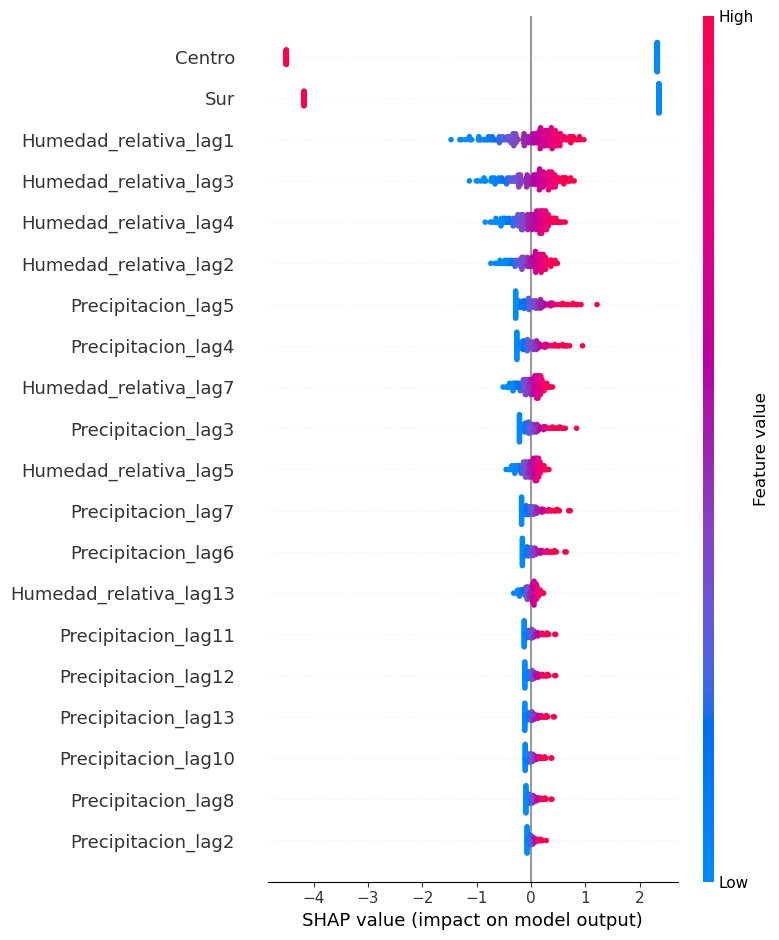

In [ ]:
explainer = shap.Explainer(lasso, X_train[lista_variables_lasso])

# Calcular los valores SHAP para todas las muestras
shap_values = explainer(X_train[lista_variables_lasso])

# Mostrar los gráficos de resumen SHAP
shap.summary_plot(shap_values, X_train[lista_variables_lasso])

## Exportando modelo en Pickle para su uso en Despliegue

In [ ]:
lista_modelos.loc[[573]].to_pickle('modeloRegresionLasso.pkl')